In [37]:
binarize = True
model_type = "classification"
remove_trend = False # Bad parameters (decrease performance)
lag_features = True
input_nan = False

save_model = True
model_name = "LightGBM"
parameters = ""

In [38]:
import pandas as pd
from src.models import build_model
from src.processing import process_features,process_target, impute_na
from src.evaluation import evaluate, evaluate_forecaster

# Inport SVR model
from sklearn.svm import SVR
import darts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
x_train = pd.read_csv("data/x_train.csv", index_col= 'DELIVERY_START', parse_dates=True)
y_train = pd.read_csv("data/y_train.csv", index_col= 'DELIVERY_START', parse_dates=True)
x_test = pd.read_csv("data/x_test.csv", index_col= 'DELIVERY_START', parse_dates=True)

## Evaluation

Score for split_ratio 0.1 :  0.523631062363011
[1 1 1 ... 1 1 1]
Score for split_ratio 0.2 :  0.5325615953603128
[1 1 1 ... 1 1 1]
Score for split_ratio 0.3 :  0.5528833678808519
[1 1 1 ... 1 1 1]
Score for split_ratio 0.4 :  0.5057662791955291
[1 1 1 ... 1 1 1]
Score for split_ratio 0.5 :  0.5547829426208384
[1 1 1 ... 1 1 1]
Score for split_ratio 0.6 :  0.5697789802694612
[1 1 1 ... 1 1 1]
Score for split_ratio 0.7 :  0.5606800786606816
[ 1  1  1 ...  1  1 -1]


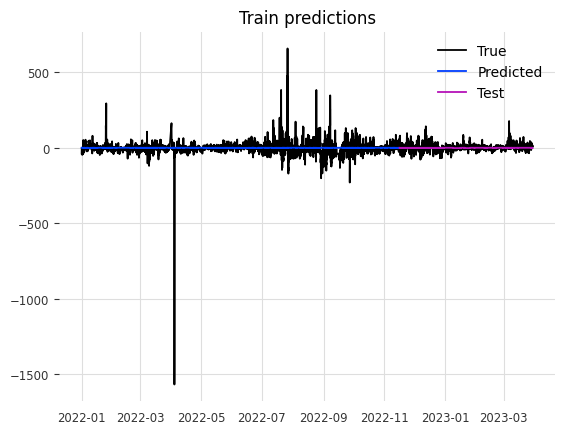

In [40]:
# Split data
for split_ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    N_train = int(len(x_train)*split_ratio)
    x_train_eval, x_test_eval, train_indices, test_indices = process_features(x_train[:N_train], x_train[N_train:], remove_trend=remove_trend, lag_features=lag_features,impute_nan=input_nan)
    y_train_eval, y_test_eval = y_train[:N_train], y_train[N_train:]
    y_train_eval, y_indices = process_target(y_train_eval, binarize=binarize, impute_nan=input_nan)
    y_test_eval, y_indices = process_target(y_test_eval, binarize=False, impute_nan=input_nan)


    # Train model
    model = build_model(type=model_type)
    if model_type == "forecaster":
        y = darts.timeseries.TimeSeries.from_series(y_train_eval)
        X = darts.timeseries.TimeSeries.from_series(x_train_eval)
        model.fit(y, future_covariates=X)
    else:
        model.fit(x_train_eval, y_train_eval)

    # Evaluate model
    if model_type == "forecaster":
        print(evaluate_forecaster(model, x_test_eval, y_test_eval, train_indices))
    else:
        print(f"Score for split_ratio {split_ratio} : ", evaluate(model, x_test_eval, y_test_eval, test_indices))
    
    print(model.predict(x_test_eval))

# Visualize predictions
import matplotlib.pyplot as plt
if model_type == "forecaster":
    #y_train_pred = model.predict(N_train,future_covariates=X)
    y_test_pred = model.predict(len(x_test_eval),future_covariates=darts.timeseries.TimeSeries.from_series(x_test_eval))
    y_test_pred = y_test_pred.pd_dataframe().squeeze()
else:
    y_train_pred = model.predict(x_train_eval)
    y_test_pred = model.predict(x_test_eval)

# Plot predictions
plt.plot(y_train.index, y_train, label='True')
if model_type != "forecaster":
    plt.plot(x_train_eval.index, y_train_pred, label='Predicted')
plt.plot(x_test_eval.index, y_test_pred, label='Test')
plt.title('Train predictions')
plt.legend()
plt.show()


## Prepare submission

In [41]:
proc_x_train, proc_x_test, train_indices, test_indices = process_features(x_train,x_test,remove_trend=remove_trend, lag_features=lag_features,impute_nan=input_nan)
proc_y_train, y_indices= process_target(y_train, binarize=binarize, impute_nan=input_nan)

# Fit with full data
model = build_model(type=model_type)
model.fit(proc_x_train, proc_y_train)

MyModel(l2_regularization=0, learning_rate=0.001, max_depth=20,
        max_leaf_nodes=127)

In [42]:
if save_model:
    from datetime import datetime
    y_test_pred = model.predict(proc_x_test)
    print(y_test_pred.shape)
    if input_nan:
        y_test_pred = y_test_pred[test_indices]
    print(len(y_test_pred))
    y_test_pred = pd.DataFrame(y_test_pred, index=x_test.index, columns=['spot_id_delta'])
    y_test_pred.to_csv(f'submission/{datetime.today().date()}_{model_name}_{parameters}.csv', index=True)

(4942,)
4942
